In [2]:
import xarray as xr
import cmocean 
import matplotlib.pyplot as plt
from matplotlib.colors import LogNorm
from mpl_toolkits.axes_grid1.inset_locator import inset_axes
import cartopy
import cartopy.crs as ccrs
import cftime
import numpy as np

In [3]:
xr.set_options(display_style='html')
%matplotlib inline                           
%config InlineBackend.figure_format='retina' 
plt.rcParams['figure.figsize'] = 12,6

## Assessment of Geostrophic Balance
This dataset contains:
- sea surface height (SSH --> zos) (referenced to a global mean of zero)
- zonal (u --> uo) and meridional (v --> vo) velocities 
at daily temporal resolution.


Goal is to assess the accuracy of the geostrophic balance approximation:
- step: horizontal gradient estimation (dh/dx, dh/dy --> convert lat/lon to distance) 
- step: geostrophic velocity estimation (leverage the geostrophic balance relationship to find geostrophic velocities u_g, v_g)
- step: calculate difference between surface velocities (uo,vo) and surface geostrophic velocities (difference between u and u_g, v and v_g)


Questions to address/explore:
- question 1: consider and plot differences between u_g and uo, v_g and vo as a function of timescale (e.g. using a single time slice vs. a long time mean)
- question 2: how sensitive are results to the length scale over which a gradient is calculated? (remember velocities have to be averaged across the same length scale). Choose a second length scale to compute gradient and estimate velocity difference (think of center difference methods and/or linear slope fitting)
- question 3: compute relative vorticity at a single time slice and for the time mean

In [4]:
glorys_jan_mar_2021 = xr.open_zarr('../data/glorys_jan_mar_2021_daily_surface')

In [5]:
print(glorys_jan_mar_2021)

<xarray.Dataset>
Dimensions:    (depth: 1, latitude: 385, longitude: 950, time: 90)
Coordinates:
  * depth      (depth) float32 0.494
  * latitude   (latitude) float32 19.25 19.33 19.42 19.5 ... 51.08 51.17 51.25
  * longitude  (longitude) float32 -87.25 -87.17 -87.08 ... -8.333 -8.25 -8.167
  * time       (time) datetime64[ns] 2021-01-01 2021-01-02 ... 2021-03-31
Data variables:
    so         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    thetao     (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    uo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    vo         (time, depth, latitude, longitude) float32 dask.array<chunksize=(12, 1, 97, 238), meta=np.ndarray>
    zos        (time, latitude, longitude) float32 dask.array<chunksize=(12, 97, 238), meta=np.ndarray>
Attributes:
    Conventions:       CF-1.11
    comment:  

In [6]:
# zos sea surfuce hieight
zos = glorys_jan_mar_2021.zos.isel(time=20).load()

/tmp/ipykernel_34867/2400041153.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  f.colorbar(pp, cax=axins1, orientation="horizontal")


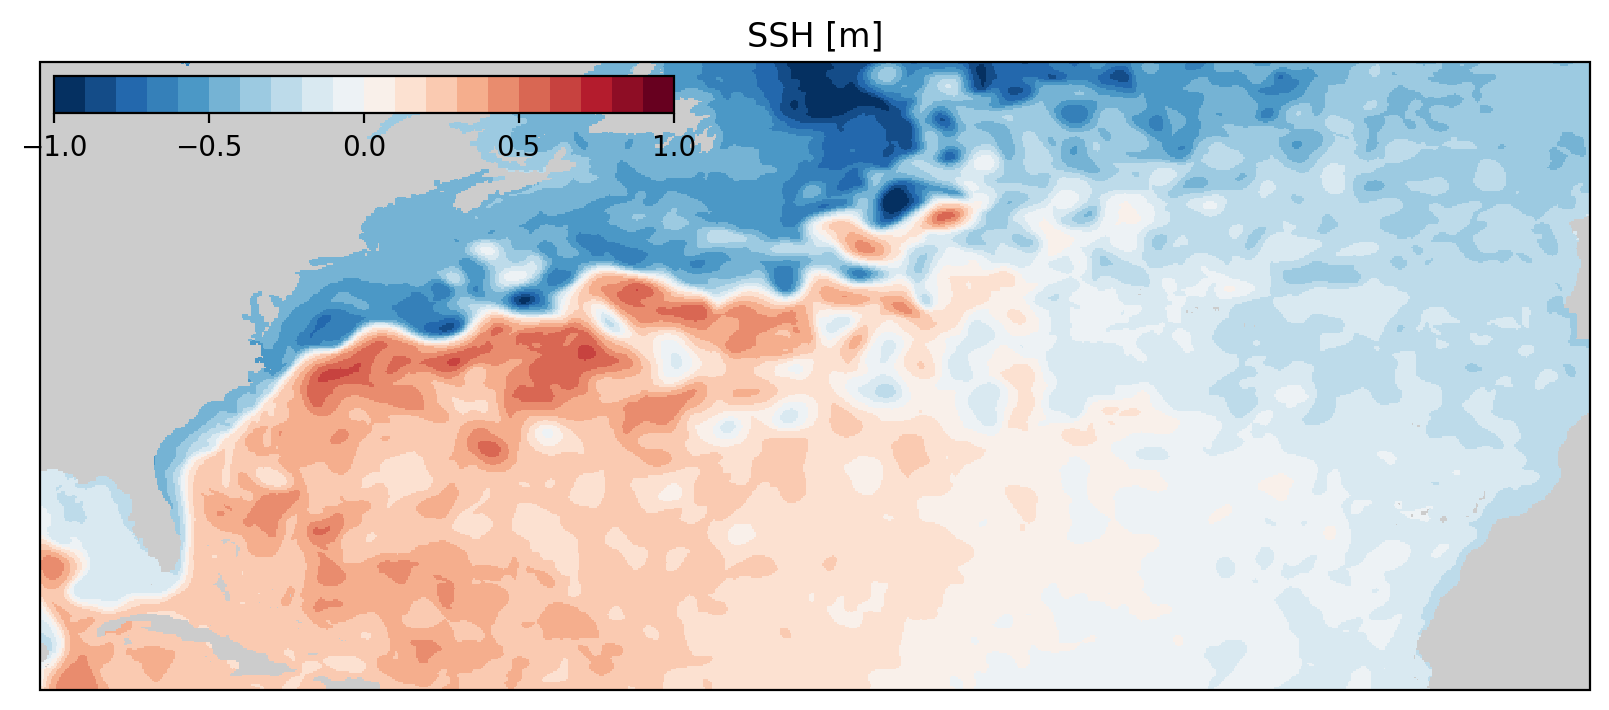

In [7]:
f, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
pp = ax.pcolor(zos.longitude, zos.latitude, zos, vmin=-1, vmax=1, \
          cmap=plt.get_cmap('RdBu_r',20),transform=ccrs.PlateCarree())
ax.set_facecolor('#cccccc')
ax.set_title('SSH [m]')
axins1 = inset_axes(ax, width="40%",height="6%",loc="upper left")
ax.xaxis.set_ticks_position("top")
f.colorbar(pp, cax=axins1, orientation="horizontal")
ax.grid()

In [7]:
# sample surface velocities
ss_u = glorys_jan_mar_2021.isel(time=20).uo.isel(depth=0).load()
ss_v = glorys_jan_mar_2021.isel(time=20).vo.isel(depth=0).load()
speed = 0.5*(ss_u**2 + ss_v**2)

/tmp/ipykernel_17325/4226807247.py:8: MatplotlibDeprecationWarning: Getting the array from a PolyQuadMesh will return the full array in the future (uncompressed). To get this behavior now set the PolyQuadMesh with a 2D array .set_array(data2d).
  f.colorbar(pp, cax=axins1, orientation="horizontal")


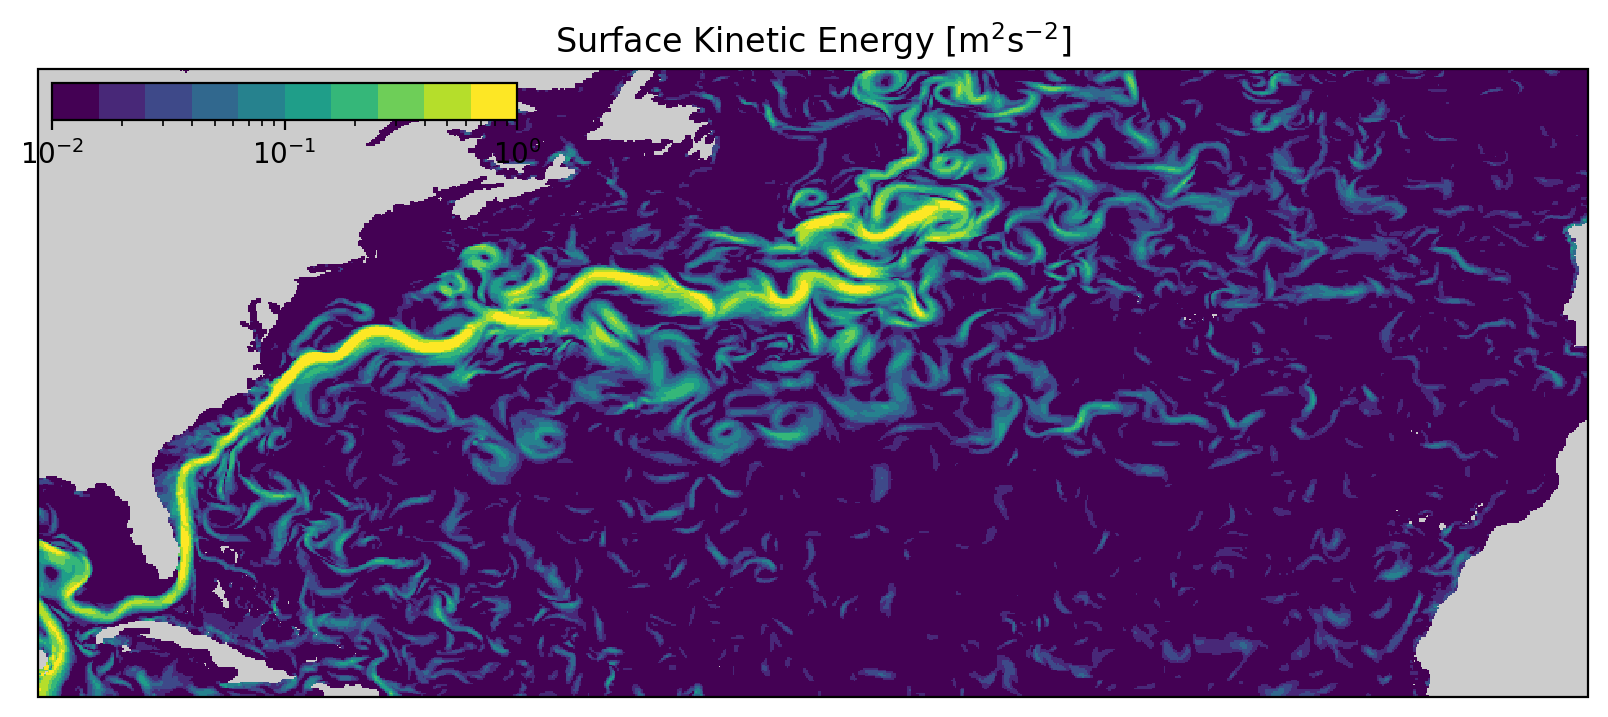

In [8]:
f, ax = plt.subplots(1,1,figsize=(10,8),subplot_kw={'projection':ccrs.PlateCarree()})
pp = ax.pcolor(ss_u.longitude, ss_u.latitude, speed, norm=LogNorm(vmin=0.01, vmax=1), \
          cmap=plt.get_cmap('viridis',10),transform=ccrs.PlateCarree())
ax.set_title(r'Surface Kinetic Energy [m$^2$s$^{-2}$]')
ax.set_facecolor('#cccccc')
axins1 = inset_axes(ax, width="30%",height="6%",loc="upper left")
ax.xaxis.set_ticks_position("top")
f.colorbar(pp, cax=axins1, orientation="horizontal")
ax.grid()

# Q1: The geoshtopic velocity

In [1]:
### attempt 2

In [21]:
# Give the dataset easy names for code ease

# key varaiables
zos = glorys_jan_mar_2021.zos  # SSH
uo = glorys_jan_mar_2021.uo  # velocity in the x dircetion
vo = glorys_jan_mar_2021.vo    # velocity in the y dircetion

# dimensions
lat = glorys_jan_mar_2021.latitude
lon = glorys_jan_mar_2021.longitude
time = glorys_jan_mar_2021.time

In [87]:
# "Goal is to assess the accuracy of the geostrophic balance approximation:"

# Step 1 is to estimate the SSH gradients - dh/dx and dh/dy (mentioned by Jake) but before that
# I must first convert lat and lon into meters 
# I have researched and deciced to do this by using the "spherical Earth approximation".

# Assumptions: 
# 1. the Earth is a sphere and not a ellipsoidal shape
# 2. the earth's radius is the same at all points
Earth_rad = 6371000 

# distance between latitudes is okay becuase the lines are equally spaced 
# the change in lat = earth's radius * the latitude spacing in radians 
# Note to self: we are currently in degrees 
# lat and lon from degrees to radians
latinrad = np.deg2rad(lat)
loninrad = np.deg2rad(lon)

# the change in lon are not similar like lat
# the lines of longitude get closer when moving from the EQ to the poles
# the change in lon = earth's radius * cos(lat in rad) * chnage in lon

# the lon needs knowlegde of the lat to understand where it is on the sphere
# therefore using meshgrid
# Make a grid of the lon and lat diff in rad using meshgrid (like what i did for the practice)
lat_grid, lon_grid = np.meshgrid(latinrad, loninrad, indexing='ij')

# Get the spaicng between each of the rad lat and rad lon
# found gradient code to help get the indivual spacingings instead of doing a loop
latdiffinrad = np.gradient(latinrad)
londiffinrad = np.gradient(loninrad)

# Compute change in lon and lat in meters
# the m change in lat = earth's radius * the latitude spacing in radians 
#mlatchange = Earth_rad * latdiffinrad 
mlatchange = Earth_rad * latdiffinrad[:, None]  
# shape is lat, lon this is NB

# the m change in lon = earth's radius * cos(lat in rad) * chnage in lon
mlonchange = Earth_rad * np.cos(lat_grid) * londiffinrad[None, :] 
# i now have dx and dy
# now i must find dh

In [88]:
# finding dh (the SSH change in the lat and lon)  
sshdiffinlat = zos.diff('latitude')
sshdiffinlon = zos.diff('longitude')

# NOTE to self when using diff i will loose a cell
# dh/dy
ssh_y_gradient = sshdiffinlat/mlatchange[1:, :]
# dh/dx
ssh_x_gradient = sshdiffinlon/mlonchange[:, 1:]

#y_gradient
#x_gradient.values

# now have the gradients 

In [89]:
# "step: geostrophic velocity estimation 
#(leverage the geostrophic balance relationship to find geostrophic velocities u_g, v_g)"

# Defining my
# graviety (assuming it to be a constant)
g = 9.81
# Earth's rotation rate [rad/s]
omega = 7.2921e-5 
# corilois parameter f = 2 * Omega * sin(lat)
f = 2 * omega * np.sin(latinrad)

# make the corilois paramter in a grid shape
f_grid = xr.DataArray(f, coords={'latitude': lat}, dims=['latitude']) # making f have dims
f_grid = f_grid.broadcast_like(zos) # alingl dimensions 

# match f grid to dhdx/dhdy grid shape
f_ssh_x_gradient = f_grid.isel(latitude=slice(0, -1))  # match ssh_x_gradient
f_ssh_y_gradient = f_grid.isel(longitude=slice(0, -1))  # match ssh_y_gradient

# geostrophic velocities
# ug = (g/f) * dh/dx
v_g =  (g / f_ssh_x_gradient) * ssh_x_gradient  # meridional from dh/dx

# ug = -(g/f) * dh/dy
u_g = -(g / f_ssh_y_gradient) * ssh_y_gradient  # zonal from dh/dy


## plotting the calculated ug and vg

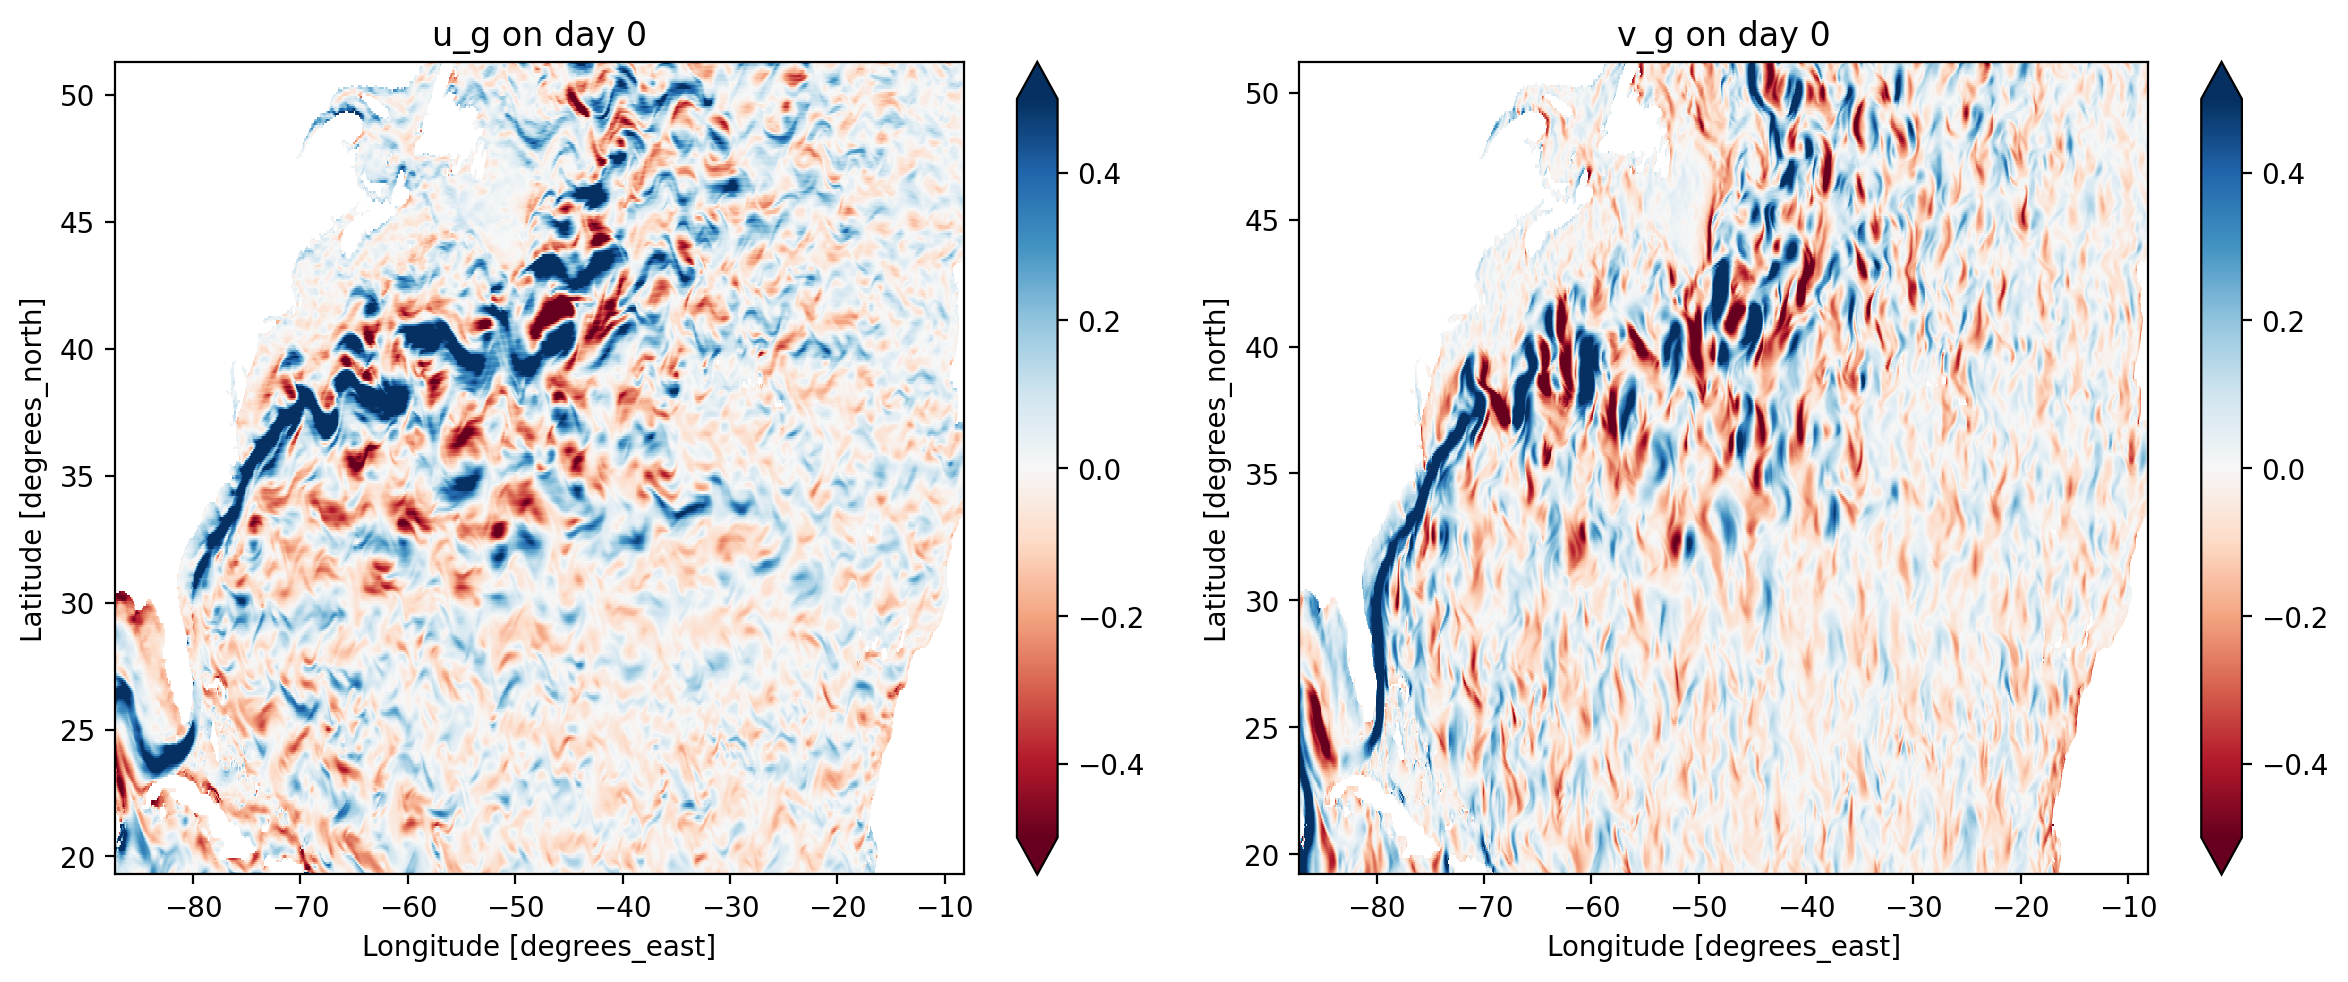

In [90]:
# calculated ug and vg daily 
day = 0  # index of day
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
u_g.isel(time=day).plot(ax=ax[0], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[0].set_title('u_g on day 0')
v_g.isel(time=day).plot(ax=ax[1], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[1].set_title('v_g on day 0')
plt.tight_layout()
plt.show()

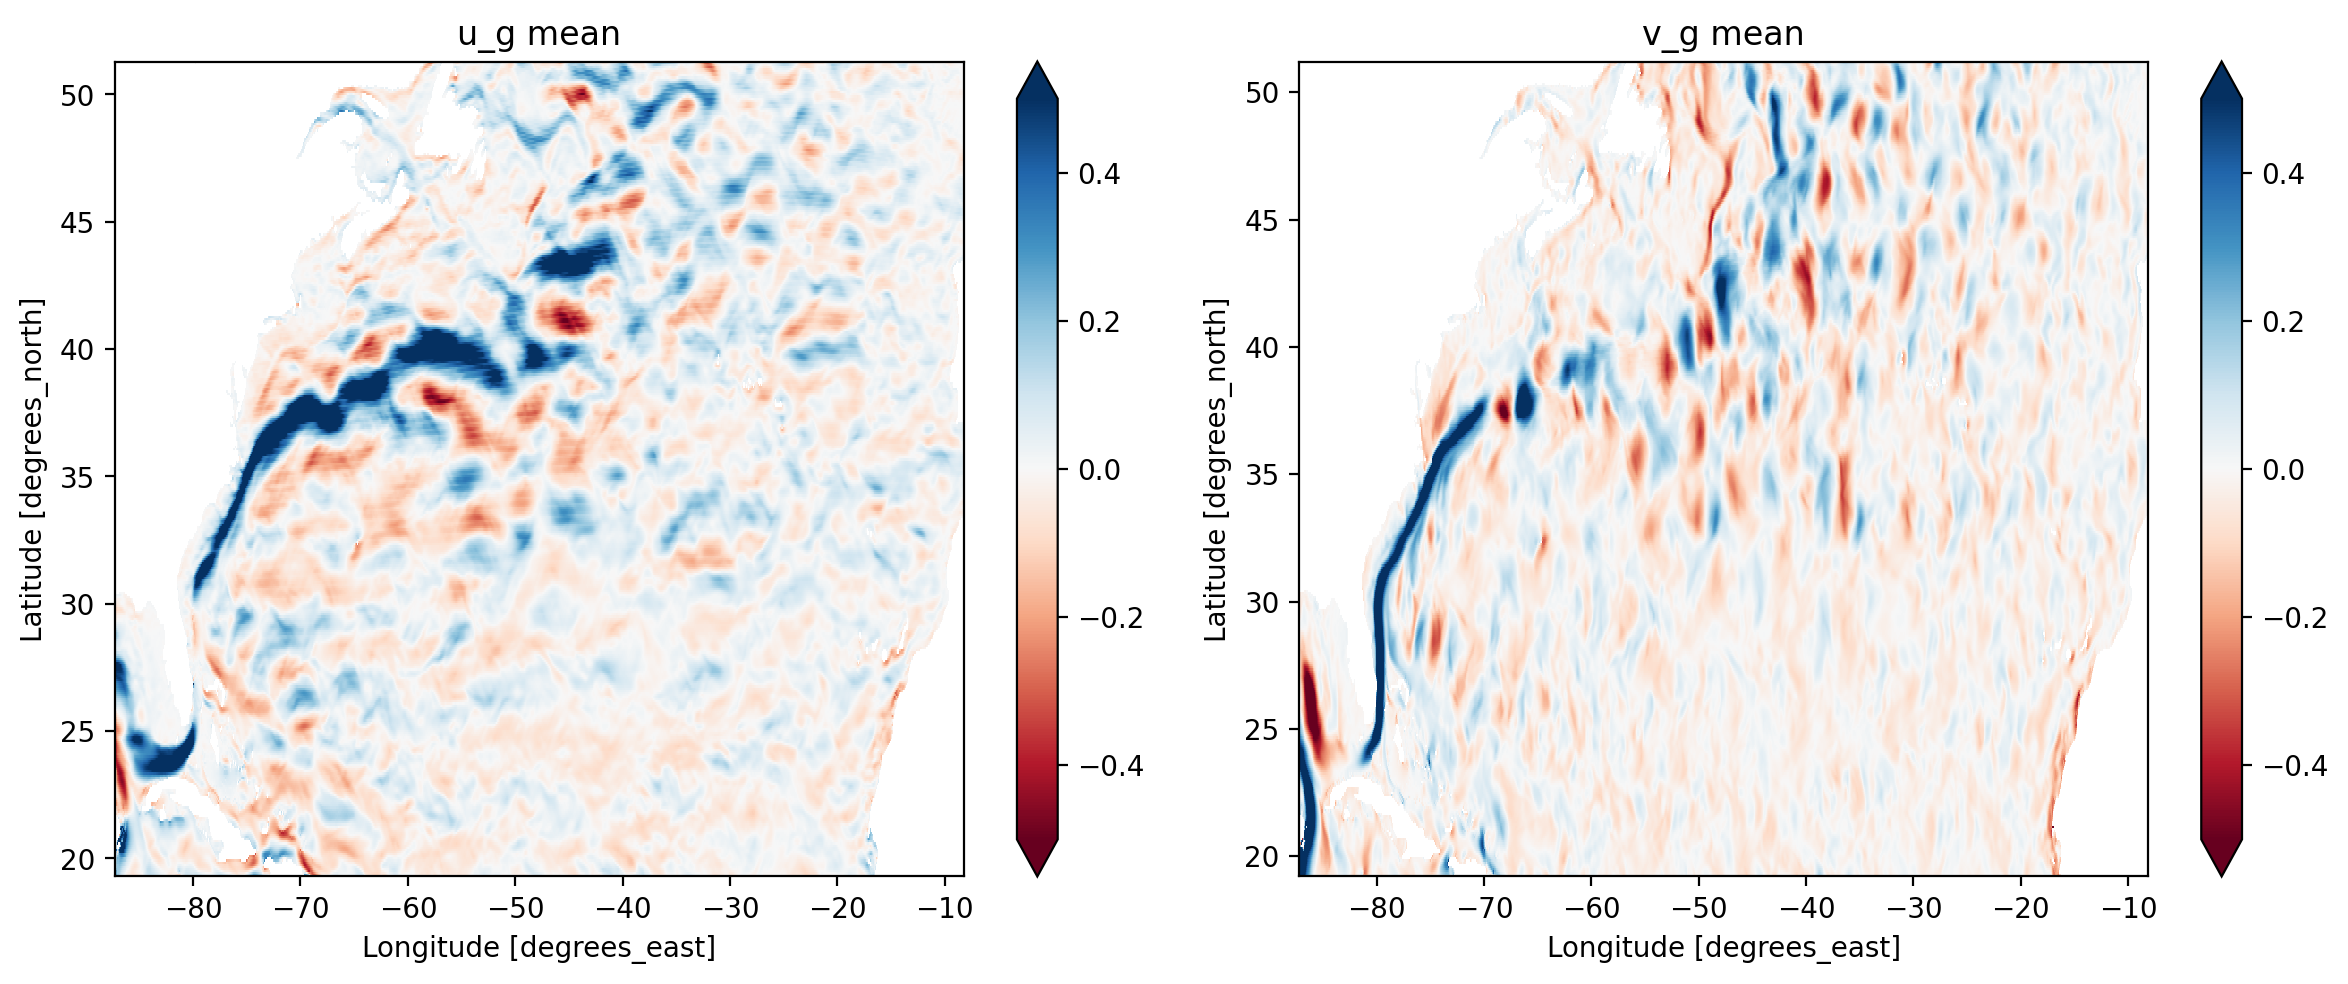

In [91]:
# calculated ug and vg mean

u_gmean=u_g.mean(dim='time')
v_gmean=v_g.mean(dim='time')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
u_gmean.plot(ax=ax[0], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[0].set_title('u_g mean')
v_gmean.plot(ax=ax[1], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[1].set_title('v_g mean')
plt.tight_layout()
plt.show()

## Plotting the calculated ug and vg verus the datasets

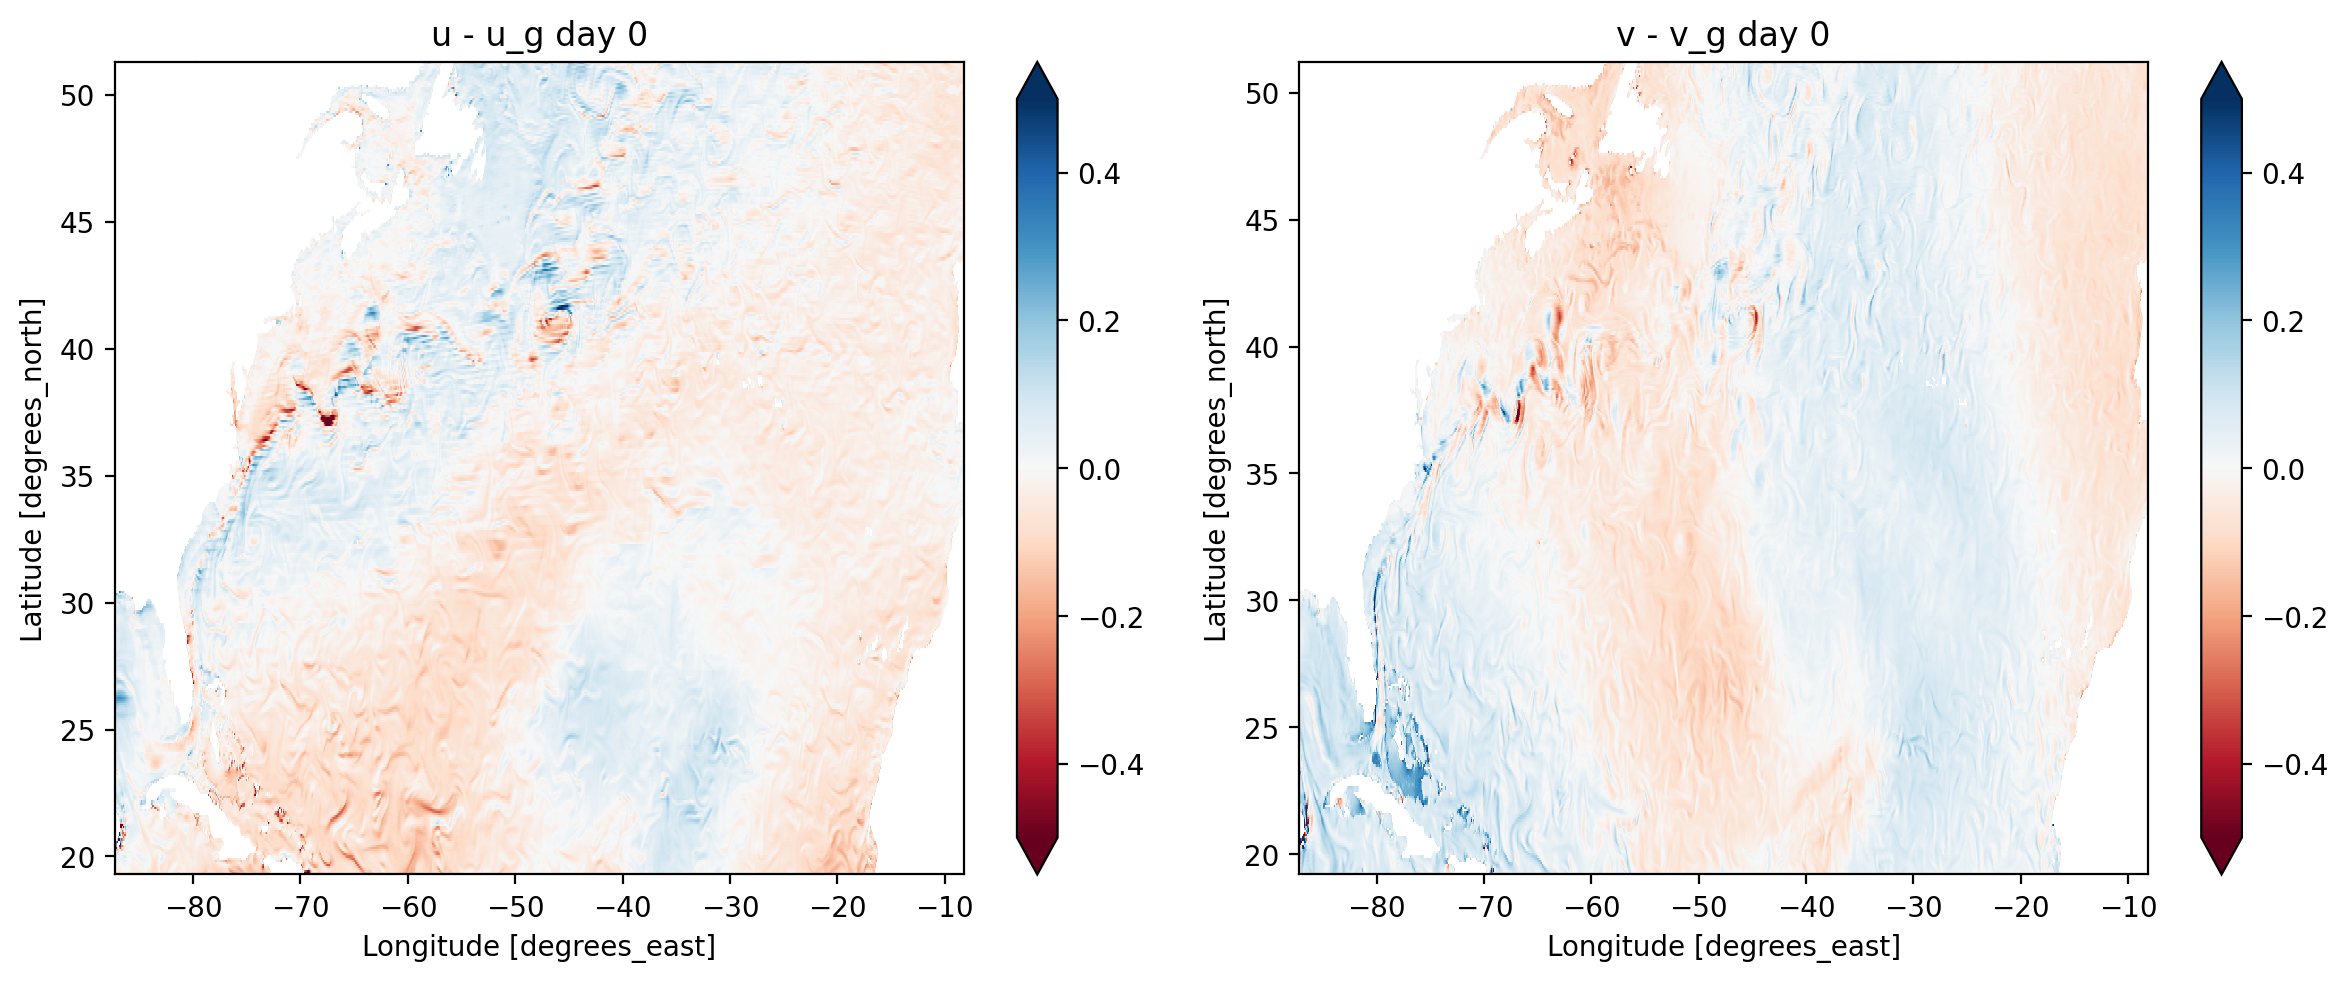

In [92]:
# Compute and Plot Differences
#daily
delta_u = uo.isel(latitude=slice(1,None ), longitude=slice(0, -1)) - u_g
delta_v = vo.isel(latitude=slice(0, -1), longitude=slice(1,None )) - v_g

day = 0  # index of day
fig, ax = plt.subplots(1, 2, figsize=(12, 5))
delta_u.isel(time=day).plot(ax=ax[0], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[0].set_title('u - u_g day 0')
delta_v.isel(time=day).plot(ax=ax[1], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[1].set_title('v - v_g day 0')
plt.tight_layout()
plt.show()

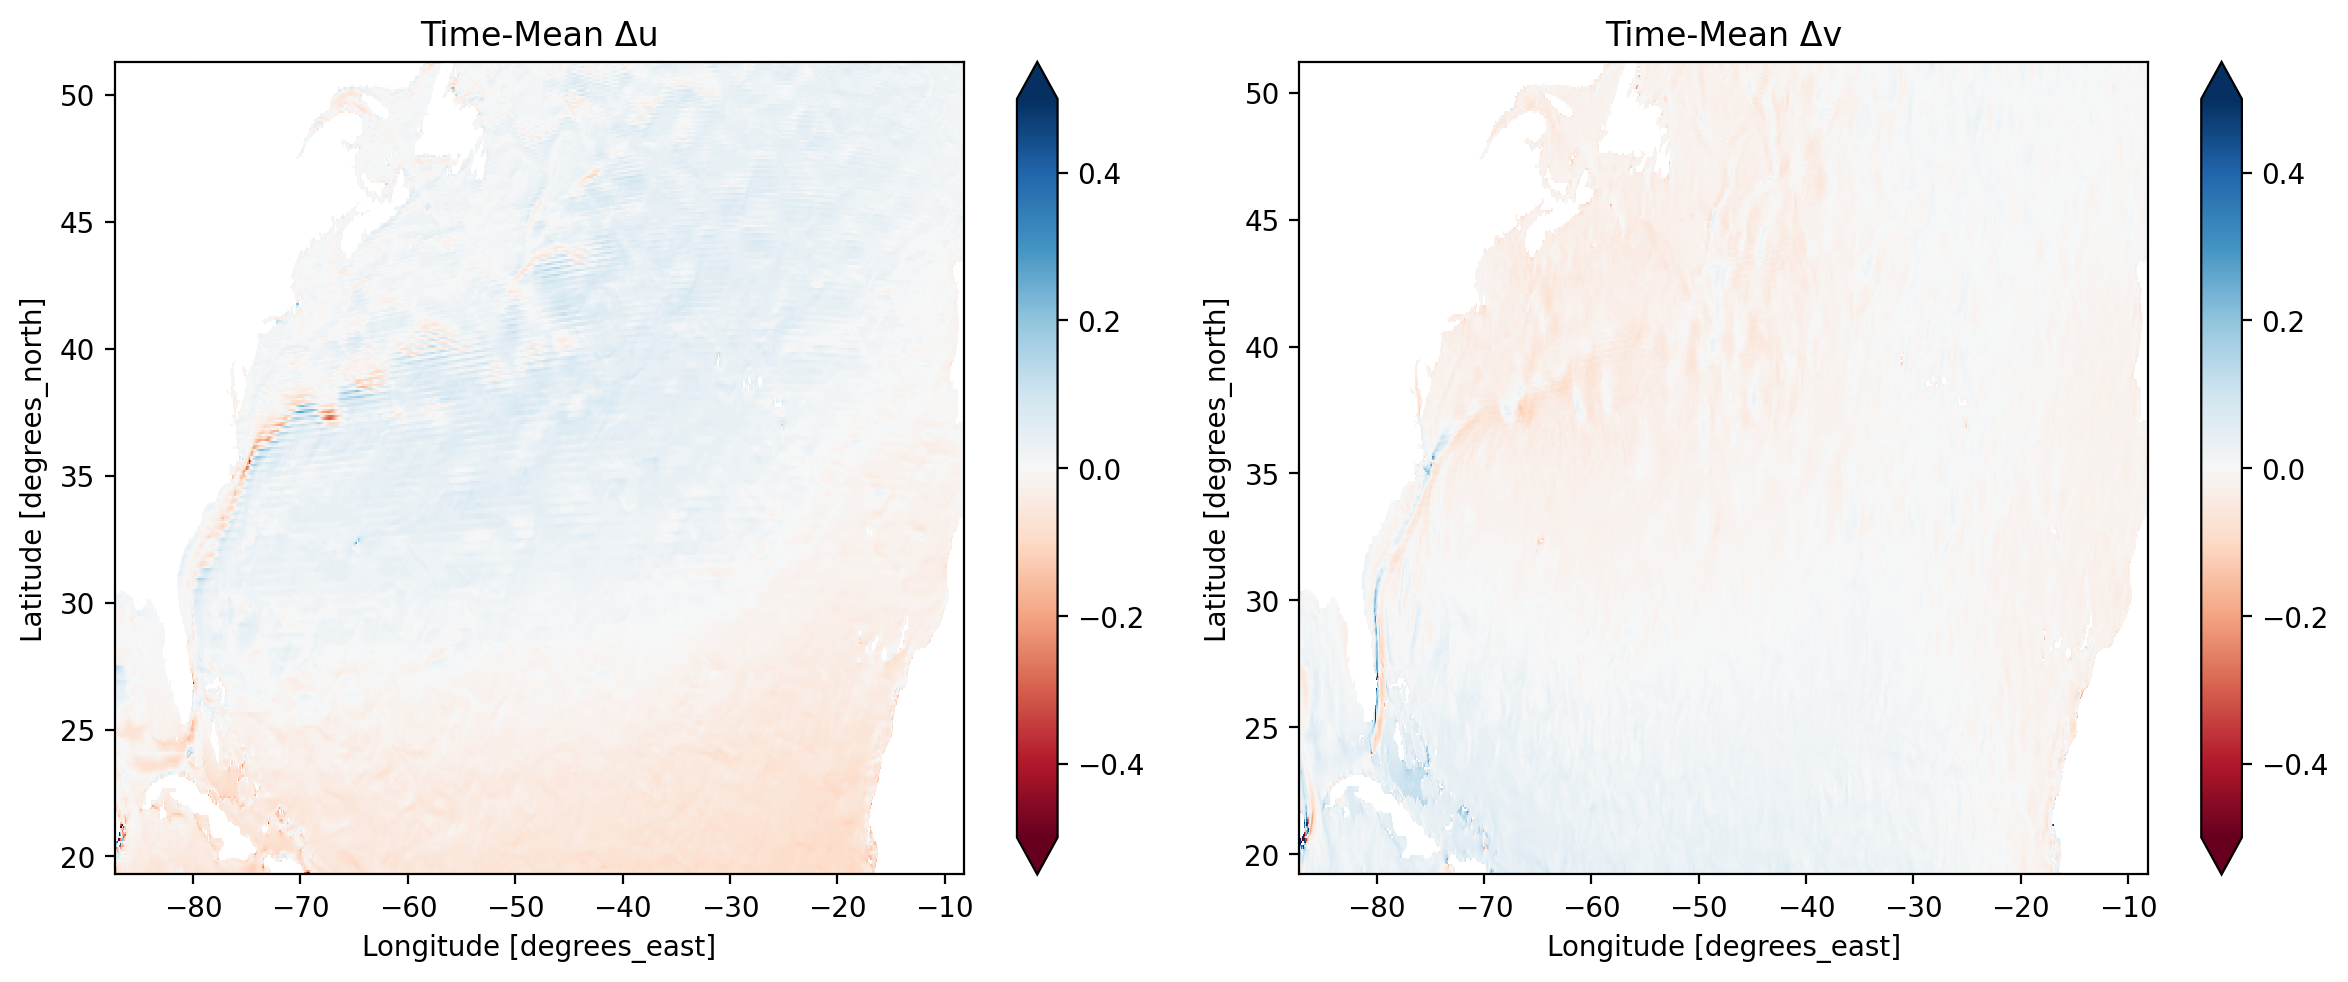

In [93]:
# full time average 

uo_mean = uo.mean(dim='time')
vo_mean = vo.mean(dim='time')

delta_u_mean = uo_mean.isel(latitude=slice(1, None), longitude=slice(0, -1)) - u_gmean
delta_v_mean = vo_mean.isel(latitude=slice(0, -1), longitude=slice(1, None)) - v_gmean

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
delta_u_mean.plot(ax=ax[0], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[0].set_title('Time-Mean Δu')
delta_v_mean.plot(ax=ax[1], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[1].set_title('Time-Mean Δv')
plt.tight_layout()
plt.show()

# Q2: Distanse sensitivites

In [94]:
# "Goal is to assess the accuracy of the geostrophic balance approximation:"

# Step 1 is to estimate the SSH gradients - dh/dx and dh/dy (mentioned by Jake) but before that
# I must first convert lat and lon into meters 
# I have researched and deciced to do this by using the "spherical Earth approximation".

# Assumptions: 
# 1. the Earth is a sphere and not a ellipsoidal shape
# 2. the earth's radius is the same at all points
Earth_rad = 6371000 

# distance between latitudes is okay becuase the lines are equally spaced 
# the change in lat = earth's radius * the latitude spacing in radians 
# Note to self: we are currently in degrees 
# lat and lon from degrees to radians
latinrad = np.deg2rad(lat)
loninrad = np.deg2rad(lon)

# the change in lon are not similar like lat
# the lines of longitude get closer when moving from the EQ to the poles
# the change in lon = earth's radius * cos(lat in rad) * chnage in lon

# the lon needs knowlegde of the lat to understand where it is on the sphere
# therefore using meshgrid
# Make a grid of the lon and lat diff in rad using meshgrid (like what i did for the practice)
lat_grid, lon_grid = np.meshgrid(latinrad, loninrad, indexing='ij')

# Get the spaicng between each of the rad lat and rad lon
# found gradient code to help get the indivual spacingings instead of doing a loop
latdiffinrad = np.gradient(latinrad)
londiffinrad = np.gradient(loninrad)

# Compute change in lon and lat in meters
# the m change in lat = earth's radius * the latitude spacing in radians 
#mlatchange = Earth_rad * latdiffinrad 
mlatchange = Earth_rad * 1.5 * latdiffinrad[:, None]  # CHANGED THE M BY *1.5
# shape is lat, lon this is NB

# the m change in lon = earth's radius * cos(lat in rad) * chnage in lon
mlonchange = Earth_rad * 1.5 * np.cos(lat_grid) * londiffinrad[None, :] 
# i now have dx and dy
# now i must find dh

In [95]:
# finding dh (the SSH change in the lat and lon)  
sshdiffinlat = zos.diff('latitude')
sshdiffinlon = zos.diff('longitude')

# NOTE to self when using diff i will loose a cell
# dh/dy
ssh_y_gradient = sshdiffinlat/mlatchange[1:, :]
# dh/dx
ssh_x_gradient = sshdiffinlon/mlonchange[:, 1:]

#y_gradient
#x_gradient.values

# now have the gradients 
# "step: geostrophic velocity estimation 
#(leverage the geostrophic balance relationship to find geostrophic velocities u_g, v_g)"

# Defining my
# graviety (assuming it to be a constant)
g = 9.81
# Earth's rotation rate [rad/s]
omega = 7.2921e-5 
# corilois parameter f = 2 * Omega * sin(lat)
f = 2 * omega * np.sin(latinrad)

# make the corilois paramter in a grid shape
f_grid = xr.DataArray(f, coords={'latitude': lat}, dims=['latitude']) # making f have dims
f_grid = f_grid.broadcast_like(zos) # alingl dimensions 

# match f grid to dhdx/dhdy grid shape
f_ssh_x_gradient = f_grid.isel(latitude=slice(0, -1))  # match ssh_x_gradient
f_ssh_y_gradient = f_grid.isel(longitude=slice(0, -1))  # match ssh_y_gradient

# geostrophic velocities
# ug = (g/f) * dh/dx
v_g_15 =  (g / f_ssh_x_gradient) * ssh_x_gradient  # meridional from dh/dx

# ug = -(g/f) * dh/dy
u_g_15 = -(g / f_ssh_y_gradient) * ssh_y_gradient  # zonal from dh/dy



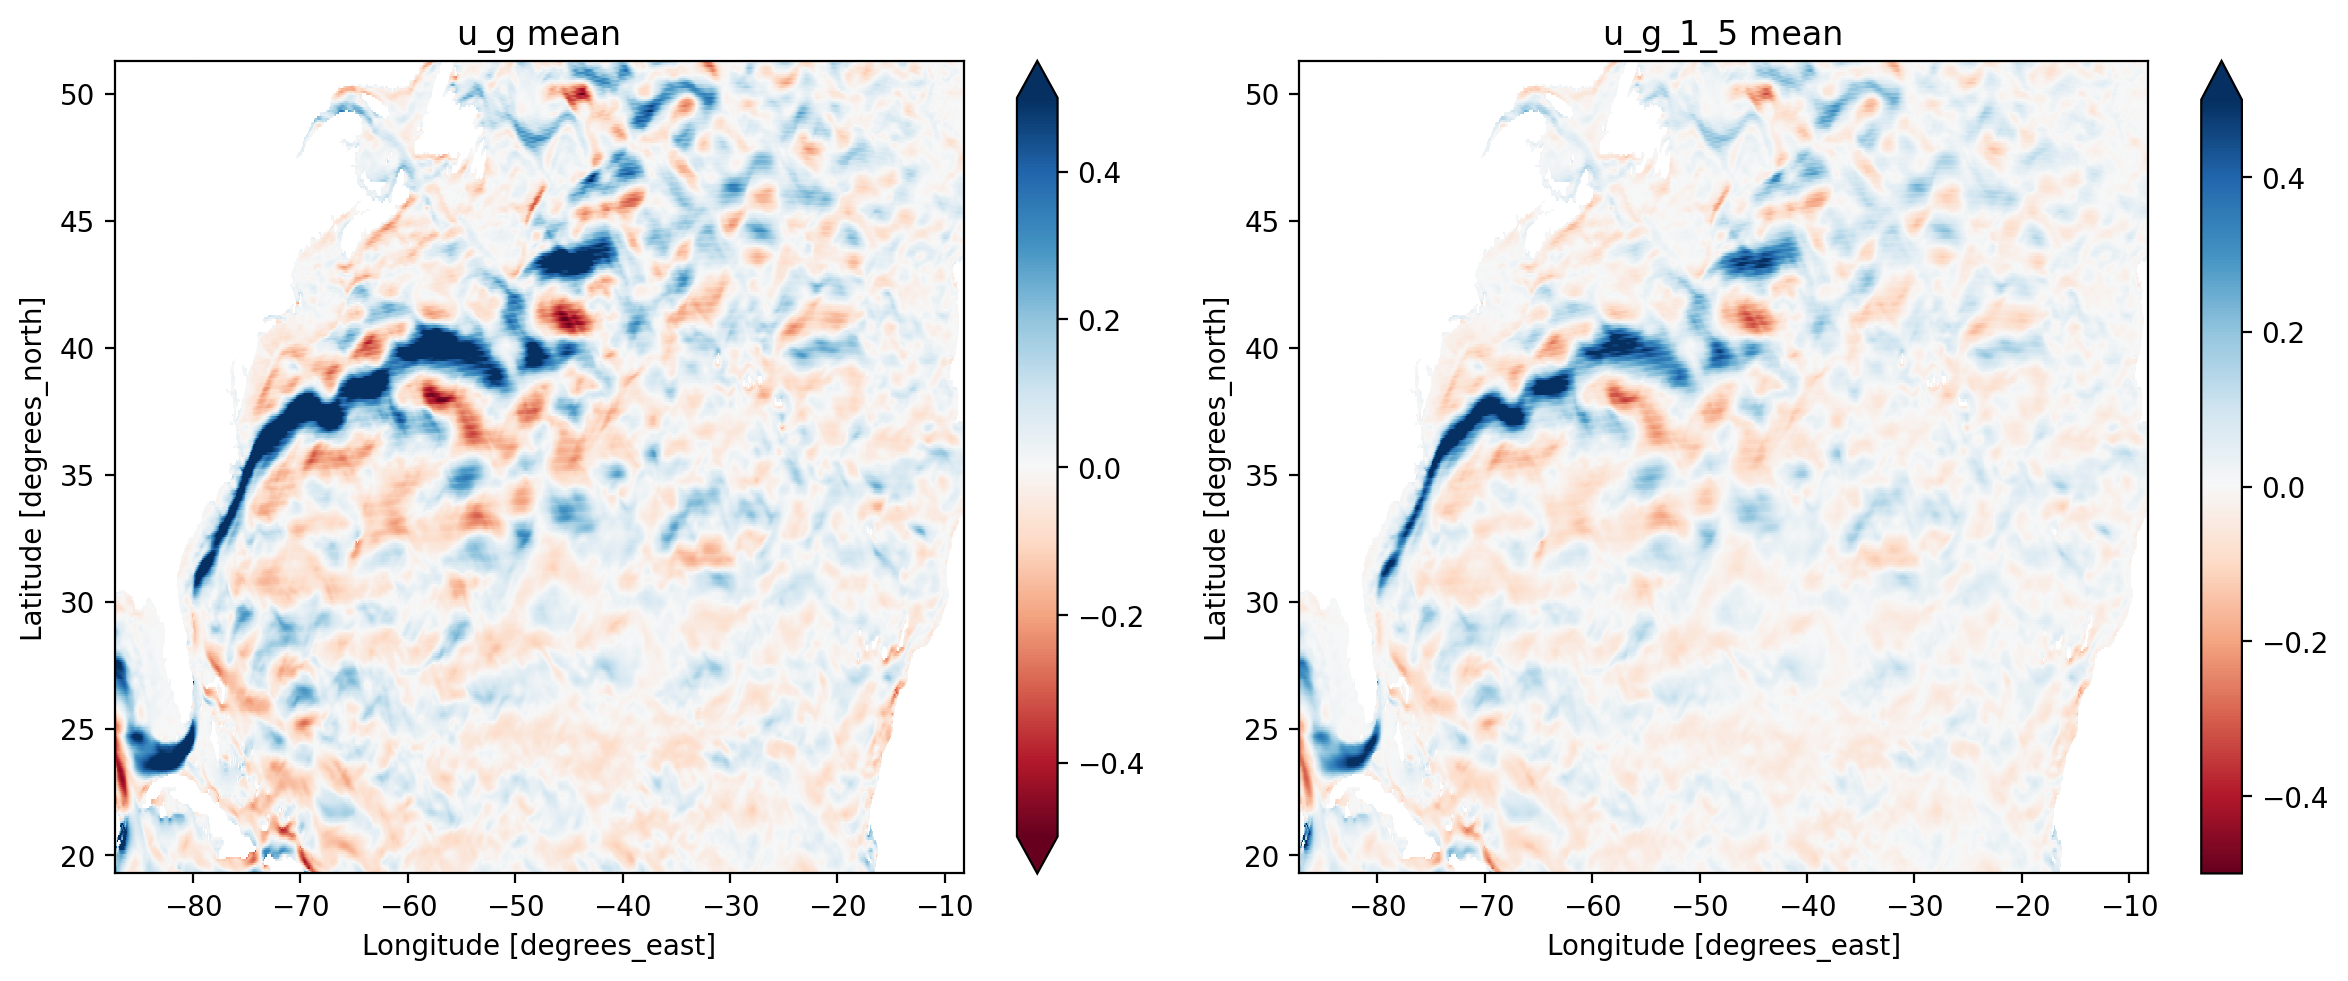

In [98]:
# calculated ug and vg mean

u_gmean_15=u_g_15.mean(dim='time')
v_gmean_15=v_g_15.mean(dim='time')

fig, ax = plt.subplots(1, 2, figsize=(12, 5))
u_gmean.plot(ax=ax[0], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[0].set_title('u_g mean')
u_gmean_15.plot(ax=ax[1], cmap='RdBu', vmin=-0.5, vmax=0.5)
ax[1].set_title('u_g_1_5 mean')
plt.tight_layout()
plt.show()

### conculsion: the same change over a longer the distance the less intense the gradient

# Q3: Compute relative vorticity at a single time slice and for the time mean